Analysis

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# Importing the CSV dataset
df = pd.read_csv('/Users/mercedes/code/mercedesf17/airbnb_analysis/dataset/new_york_listings_2024.csv')

In [3]:
df.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,rating,bedrooms,beds,baths
0,1312228,Rental unit in Brooklyn · ★5.0 · 1 bedroom,7130382,Walter,Brooklyn,Clinton Hill,40.683710,-73.964610,Private room,55.0,...,2015-12-20,0.03,1,0,0,No License,5.0,1,1,Not specified
1,45277537,Rental unit in New York · ★4.67 · 2 bedrooms ·...,51501835,Jeniffer,Manhattan,Hell's Kitchen,40.766610,-73.988100,Entire home/apt,144.0,...,2023-05-01,0.24,139,364,2,No License,4.67,2,1,1
2,971353993633883038,Rental unit in New York · ★4.17 · 1 bedroom · ...,528871354,Joshua,Manhattan,Chelsea,40.750764,-73.994605,Entire home/apt,187.0,...,2023-12-18,1.67,1,343,6,Exempt,4.17,1,2,1


In [4]:
print(f'The initial number of rows of the dataframe is {len(df)}.')

The initial number of rows of the dataframe is 20758.


In [5]:
# Now I will start some data cleaning

# First, checking how many rows have "No Rating"
rows_no_rating = len(df[df['rating'] == 'No rating'])
print(f'The number of rows with no rating is {rows_no_rating}.')

# Second, dropping those rows and check the rows of the updates dataframe

df.drop(df[(df['rating']== 'No rating')].index,inplace = True)
new_len = len(df)
print(f'After dropping the rows with no rating, the dataframe has {new_len} rows.')


The number of rows with no rating is 3593.
After dropping the rows with no rating, the dataframe has 17165 rows.


Neighbourhood and room type exploration

In [10]:
unique_neighbourhoods = df.nunique()['neighbourhood']
unique_airbnb_types = df.nunique()['room_type']

print(f"The AirBnbs of this dataset are spread across {unique_neighbourhoods} neighbourhoods.")
print(f"The dataset includes {unique_airbnb_types} different types of accomodation types.")

The AirBnbs of this dataset are spread across 219 neighbourhoods.
The dataset includes 4 different types of accomodation types.


Price exploration

In [11]:
df.describe()[['price']]

# Observations: There is a huge difference between min, max and mean price per night. This might indicate there are some outliers
# and I would want to delete them potentially. In the next steps, I will try to plot the distriubtion visually.

,price
count,17165.000000
mean,187.151937
std,1113.765328
min,10.000000
25%,83.000000
50%,125.000000
75%,198.000000
max,100000.000000


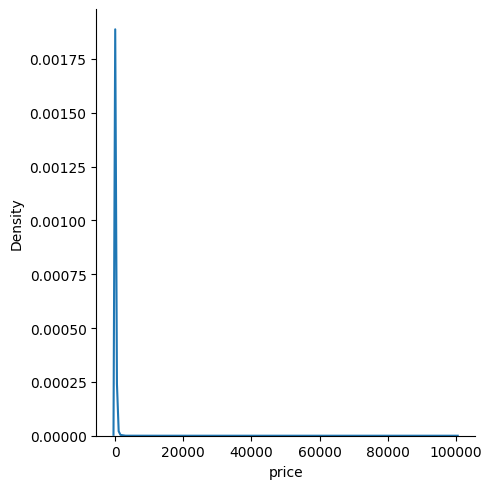

In [14]:
# The majority of prices seem to be clustered toward the lower end of the scale

sns.displot(df, x = 'price', kind="kde")

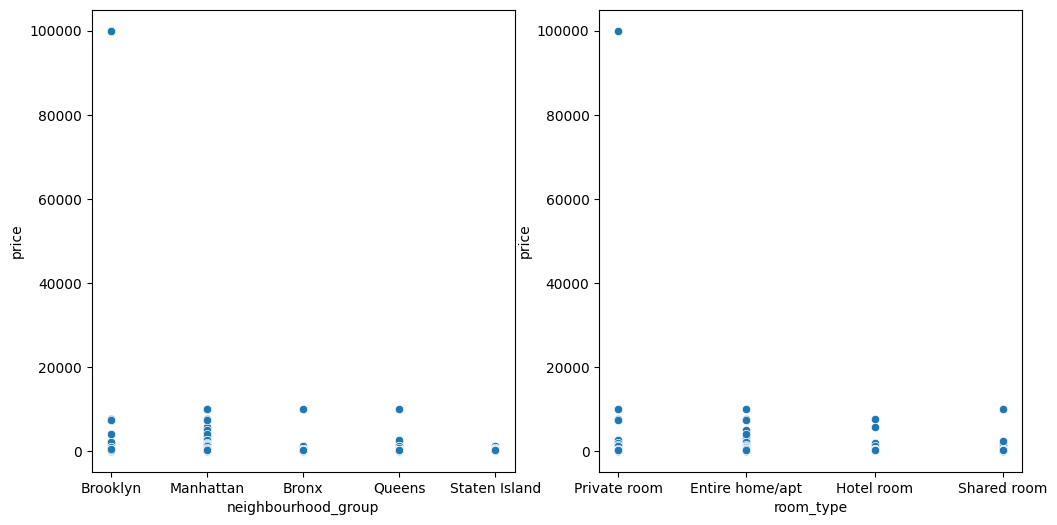

In [21]:
# The scatterplot clearly shows an outlier in the higher end
fig, axes = plt.subplots(1,2,figsize=(12, 6))

sns.scatterplot(data=df, x='neighbourhood_group', y='price',ax=axes[0])
sns.scatterplot(data=df, x='room_type', y='price',ax=axes[1])

plt.show()

In [28]:
# Calculating the first and third quartiles and flagging the data points
# that fall significantly beyond this range as outliers

Q1 = df['price'].quantile(0)
Q3 = df['price'].quantile(0.99)
IQR = Q3 - Q1

threshold = 1.5
outliers = df[(df['price'] < Q1 - threshold * IQR) | (df['price'] > Q3 + threshold * IQR)]
print(f'The number of outliers considering the last 1% percentile is {len(outliers)}.')

The number of outliers considering the last 1% percentile is 28.


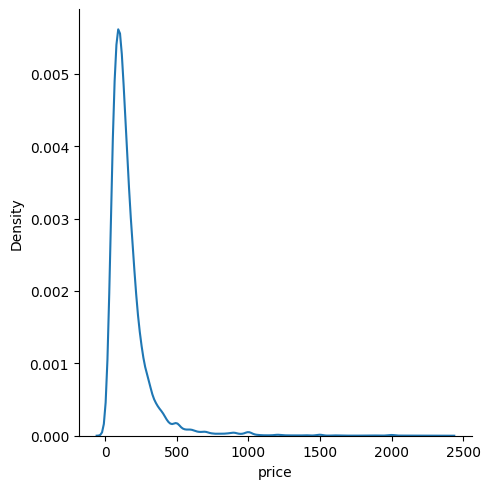

In [31]:
# Let's drop the outliers

df.drop(df[(df['price'] < Q1 - threshold * IQR) | (df['price'] > Q3 + threshold * IQR)].index,inplace = True)

# And check again the distribution visually

sns.displot(df, x = 'price', kind = 'kde')

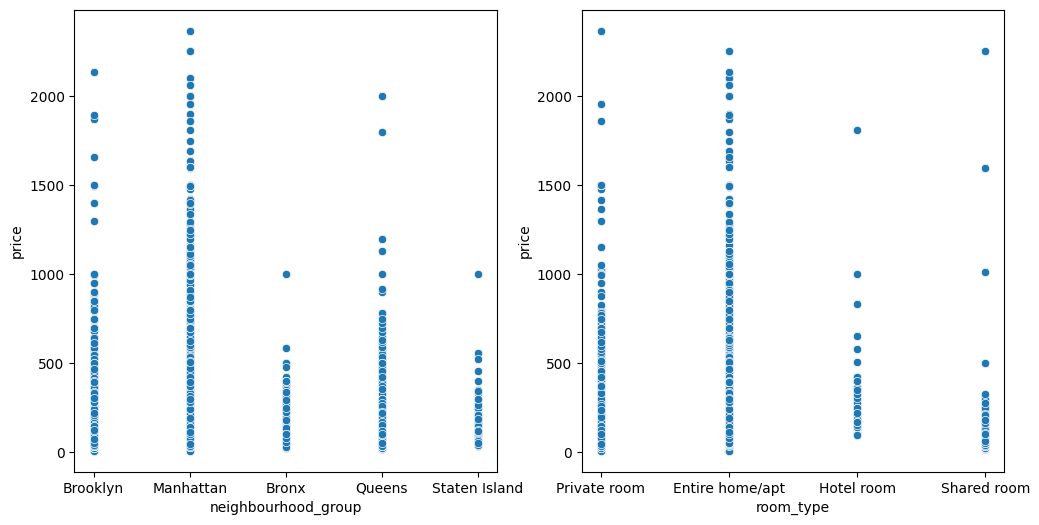

In [32]:
fig, axes = plt.subplots(1,2,figsize=(12, 6))

sns.scatterplot(data=df, x='neighbourhood_group', y='price',ax=axes[0])
sns.scatterplot(data=df, x='room_type', y='price',ax=axes[1])

plt.show()

Hot-encoding some values so that I can start trying out predictive Machine Learning models

In [168]:
# Hot-encoding the room type
encoded_data = pd.get_dummies(df, columns= ['room_type', 'neighbourhood_group'])
encoded_data.head(3)

,id,name,host_id,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,...,baths,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,1312228,Rental unit in Brooklyn · ★5.0 · 1 bedroom,7130382,Walter,Clinton Hill,40.683710,-73.964610,55.0,30,3,...,Not specified,False,False,True,False,False,True,False,False,False
1,45277537,Rental unit in New York · ★4.67 · 2 bedrooms ·...,51501835,Jeniffer,Hell's Kitchen,40.766610,-73.988100,144.0,30,9,...,1,True,False,False,False,False,False,True,False,False
2,971353993633883038,Rental unit in New York · ★4.17 · 1 bedroom · ...,528871354,Joshua,Chelsea,40.750764,-73.994605,187.0,2,6,...,1,True,False,False,False,False,False,True,False,False


In [169]:
# The  bedrooms column does contain a string instead of a numberical value for string. I replaced the rows where it is "Studio"
# With 0s
encoded_data.replace({'Studio': 0}, inplace = True)

In [170]:
# Determining X and y

X = encoded_data[['room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']]
y = encoded_data['price']

# Splitting the data

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# Instiating the model

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
r2


0.11863284552941167

In [171]:
X1 = encoded_data[['bedrooms']]
y1 = encoded_data['price']

# Splitting the data

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1, test_size = 0.2)

# Instiating the model

model1 = LinearRegression()

model1.fit(X_train1, y_train1)

y_pred1 = model1.predict(X_test1)

r2_ = r2_score(y_test1, y_pred1)
r2_

0.16819444777051396

In [172]:
X2 = encoded_data[['beds']]
y2 = encoded_data['price']

# Splitting the data

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, test_size = 0.2)

# Instiating the model

model2 = LinearRegression()

model2.fit(X_train2, y_train2)

y_pred2 = model2.predict(X_test2)

r2__ = r2_score(y_test2, y_pred2)
r2__

0.16799016442415582

In [173]:
X4 = encoded_data[['neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan','neighbourhood_group_Queens','neighbourhood_group_Staten Island']]
y4 = encoded_data['price']

# Splitting the data

X4_train, X4_test, y4_train, y4_test = train_test_split(X4,y4, test_size = 0.2)

# Instiating the model

model4 = LinearRegression()

model4.fit(X4_train, y4_train)

y4_pred = model4.predict(X4_test)

r2____ = r2_score(y4_test, y4_pred)
r2____


0.04293450964785328

In [174]:
X3 = encoded_data[['room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'beds', 'bedrooms']]
y3 = encoded_data['price']

# Splitting the data

X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3, test_size = 0.2)

# Instiating the model

model3 = LinearRegression()

model3.fit(X3_train, y3_train)

y3_pred = model3.predict(X3_test)

r2___ = r2_score(y3_test, y3_pred)
r2___

0.2514020048776906